### An example of the SIGW inverse problem

In [1]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from src.omega_gw_grid import OmegaGWGrid
from src.model import fixed_node_model
import pybobyqa
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


#### A simple test curvature power spectrum and $\Omega_{\rm GW}$ calculated using the GT and MP method

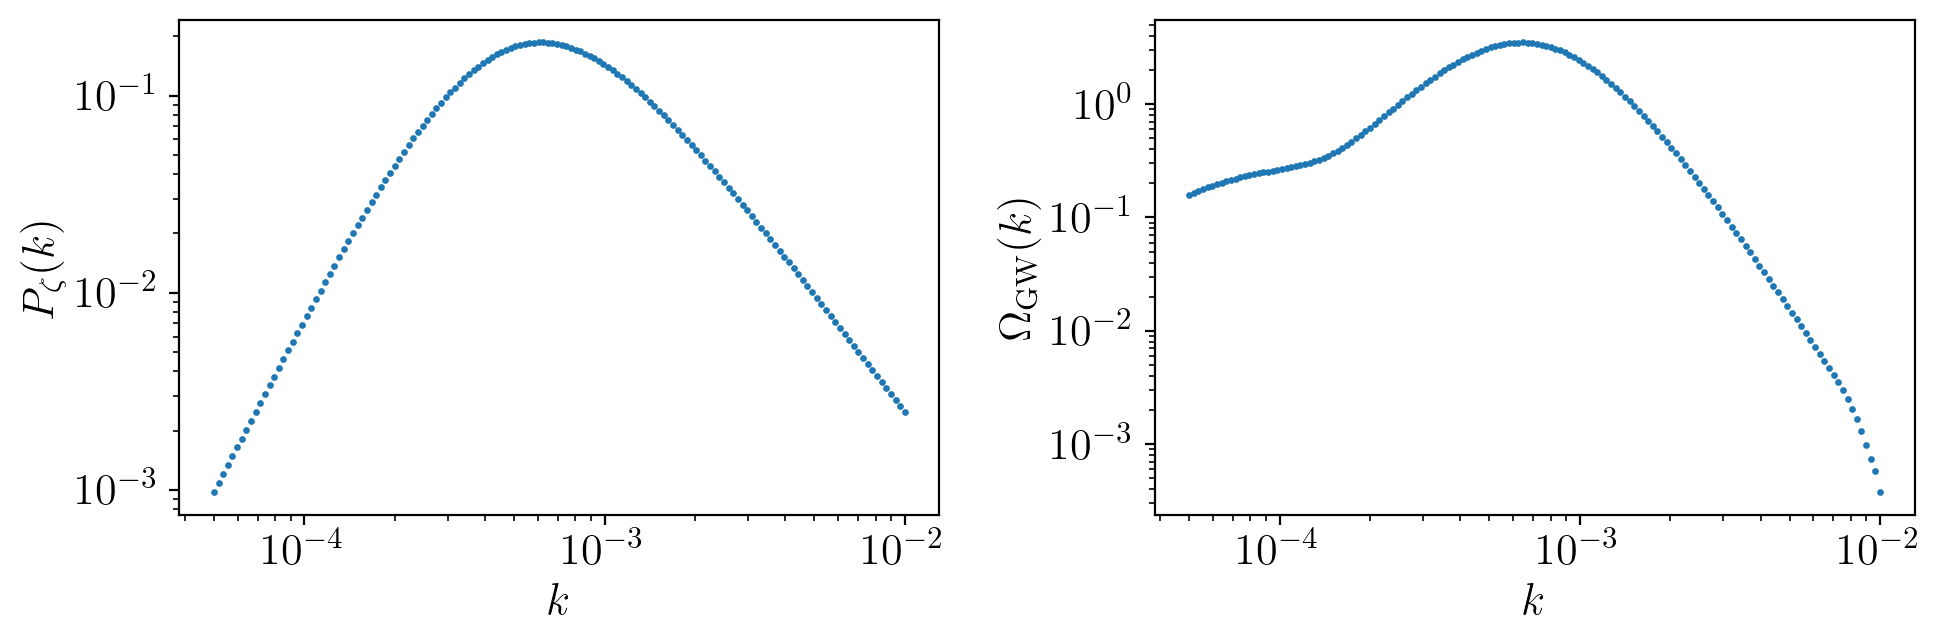

In [2]:
# set up the power spectrum and omgw
psize = 150
ksize = 150
p_arr = np.geomspace(5e-5,1e-2,psize)
k_arr = np.geomspace(5e-5,1e-2,ksize)

def pz(p,pstar=5e-4,n1=3,n2=-2,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    osc = (1 + 16.4*np.cos(1.4*np.log(p/1.))**2)
    return pl1 * pl2 #*osc

omgw_calculator = OmegaGWGrid(omgw_karr=k_arr,pz_karr=p_arr)

pz_amp = pz(k_arr)
omgw_amp = omgw_calculator(pz_func=pz)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(k_arr,omgw_amp,s=2)
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

#### Let's set up the inference with an uncertainity on the GWB

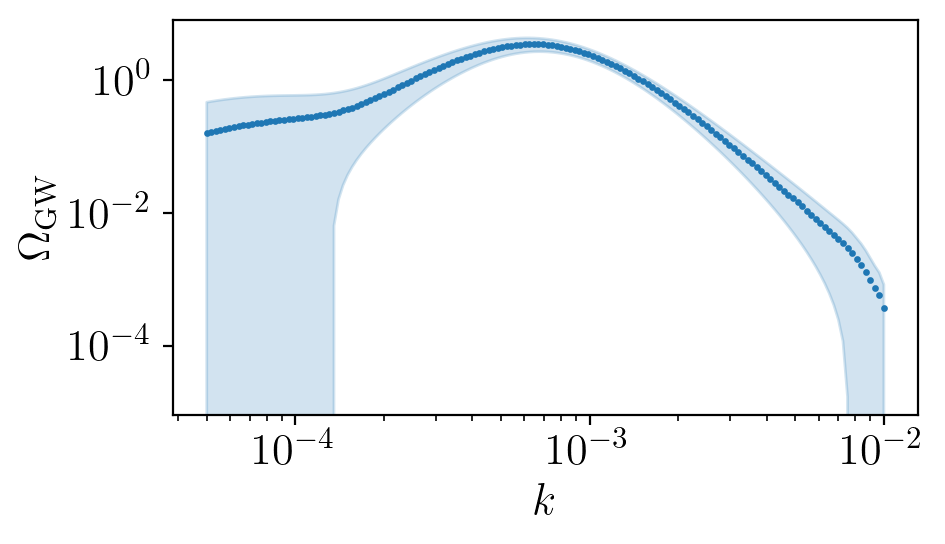

In [3]:
kstar = 1e-3
omks_sigma = omgw_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.1) # 10% error at kstar + more towards edges
omgw_cov = jnp.diag(omks_sigma)
fig,ax = plt.subplots(1,1,figsize=(5,3.))
ax.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax.scatter(k_arr,omgw_amp,s=2)
ax.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout()

In [ ]:
# Set up the fixed node interpolator
kmin, kmax = min(p_arr), max(p_arr)
pz_model = fixed_node_model(nbins=5,pz_kmin=kmin,pz_kmax=kmax,
                            omgw_karr=k_arr,omgw_means=omgw_amp,
                            omgw_cov=omgw_cov,omgw_method='fast')

In [5]:
# run the HMC
samples, _ = pz_model.run_hmc_inference()

sample: 100%|██████████| 512/512 [00:23<00:00, 22.26it/s, 7 steps of size 3.07e-01. acc. prob=0.85] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -6.23      1.37     -6.44     -7.99     -4.08     64.18      1.05
      y[1]     -3.15      0.13     -3.15     -3.35     -2.92     41.40      1.11
      y[2]     -1.70      0.03     -1.70     -1.74     -1.66    172.82      1.01
      y[3]     -3.56      0.12     -3.55     -3.74     -3.37     99.29      1.01
      y[4]     -5.75      0.93     -5.65     -7.29     -4.26    131.74      1.00

Number of divergences: 0


#### Now we plot some realisations of the inferred $P_{\zeta}$ from the MCMC samples

(16, 150)
(16, 150)


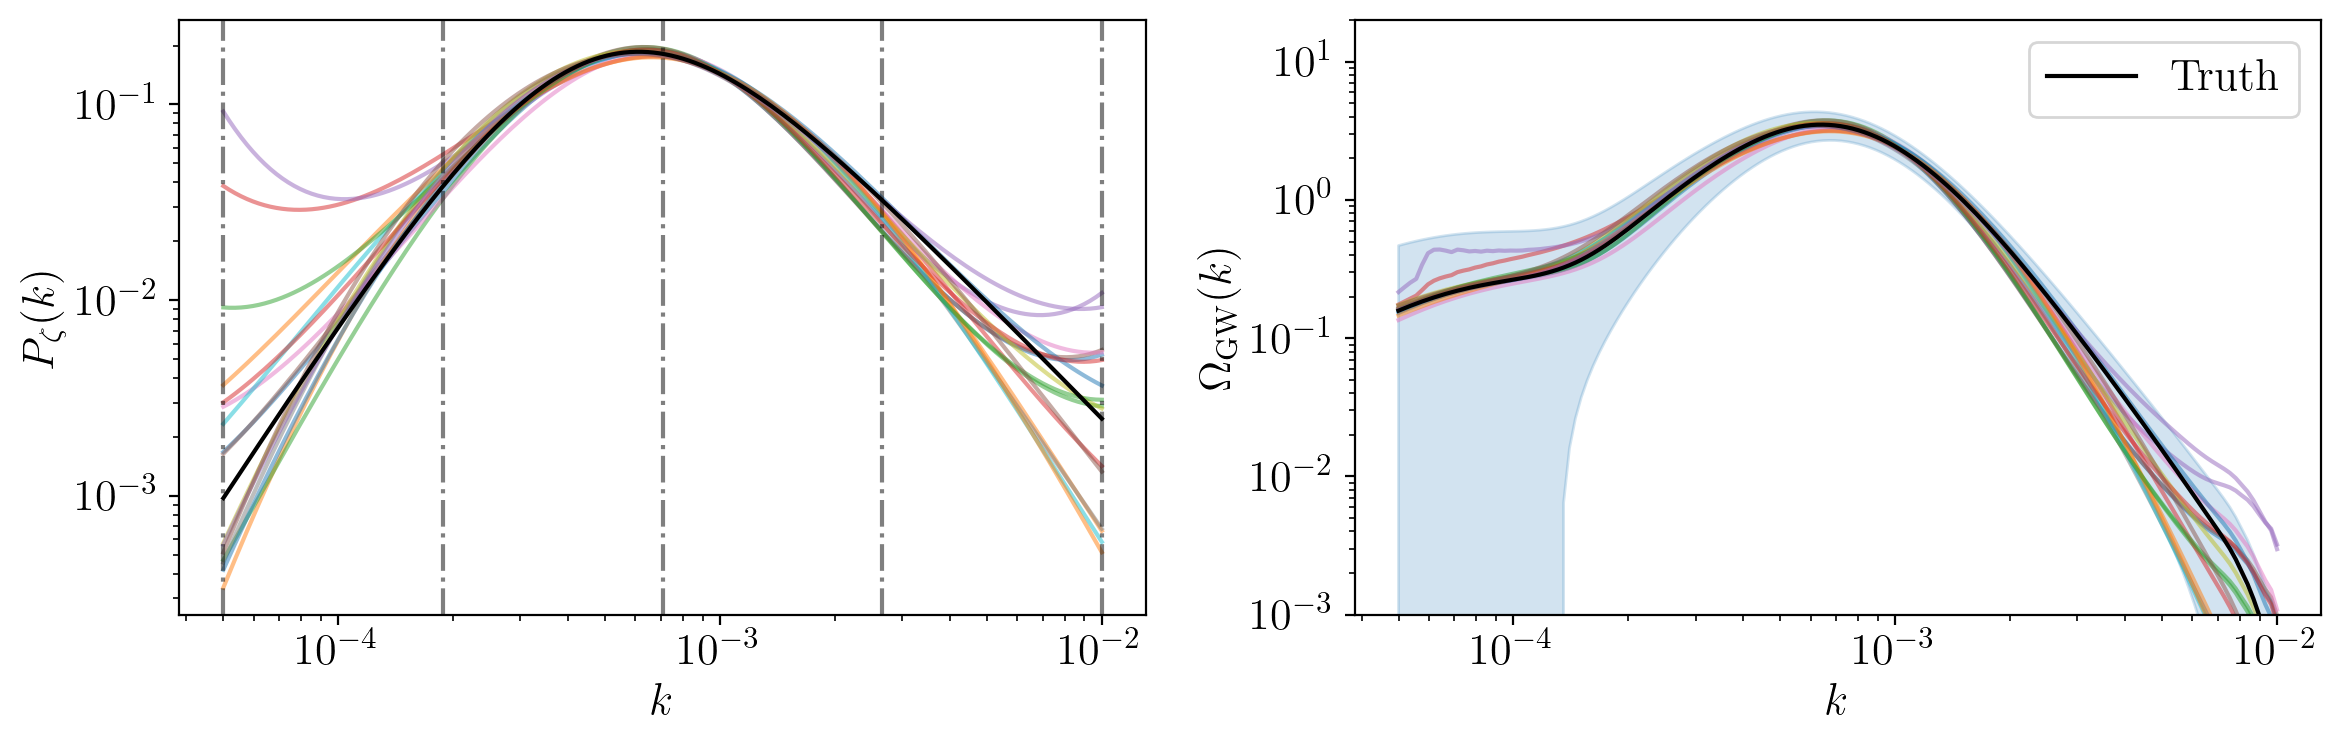

In [6]:
from src.model import spline_predict
nodes = pz_model.log_k_nodes
f = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
pz_amps = vmap(f,)(samples['y'][::16])
print(pz_amps.shape)
omgw_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,omgw_calculator.omkij)
print(omgw_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for pz in pz_amps:
    ax1.loglog(p_arr,pz,alpha=0.5)
for om in omgw_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(1e-3,2e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()
